In [2]:
import os
import numpy as np
import pandas as pd

from kaggle_datasets import KaggleDatasets
import tensorflow as tf


from tensorflow.keras.applications import DenseNet121

import cv2
from IPython.display import SVG

!pip install plotly

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

!pip install seaborn

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

D0528 16:15:59.743572010   10497 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0528 16:15:59.743598071   10497 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0528 16:15:59.743601359   10497 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0528 16:15:59.743677154   10497 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0528 16:15:59.743681639   10497 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0528 16:15:59.743683937   10497 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0528 16:15:59.743689817   10497 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0528 16:15:59.

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [3]:
TRAIN_PATH = '/kaggle/input/sensors-data/Sensors_data/Temperature/Train/'
TEST_PATH = '/kaggle/input/sensors-data/Sensors_data/Temperature/Test/'
TRAIN_FOLDERS = np.sort(os.listdir(TRAIN_PATH))
TEST_FOLDERS = np.sort(os.listdir(TEST_PATH))

In [4]:
print(TRAIN_FOLDERS)

['Autumn' 'Spring' 'Summer' 'Winter']


In [5]:
train_images = []

path_root = '/kaggle/input/sensors-data/Sensors_data/Temperature/Test/'
for mod in TEST_FOLDERS:
    images = os.listdir(path_root + mod)[:1]
    for file_name in images:
        image_path = path_root+ mod+'/'+file_name
        
        if image_path[-4:].upper() == 'JPEG' or image_path[-3:].upper() == 'PNG' or image_path[-3:].upper() == 'JPG':
            orig_image = cv2.imread(image_path)
            image = orig_image[80:-80, 110:-100]        # cropping image
            train_images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        else:
            continue
        
train_images = np.array(train_images)

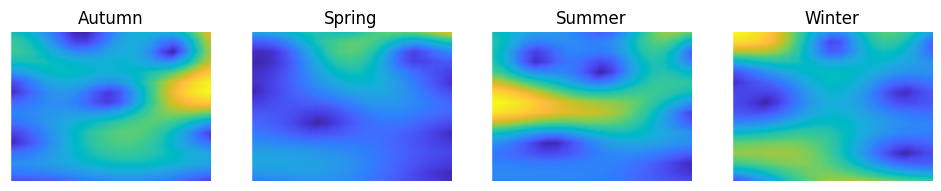

In [6]:
def display_images():
    rows, col = 2, 5
    #rows, col = 2, 2
    fig = plt.figure(figsize=(15,7))
    for index, image in enumerate(train_images):
        ax = fig.add_subplot(rows, col, index+1)
        ax.imshow(train_images[index])
        ax.set_title(TRAIN_FOLDERS[index])
        ax.axis('off')
        
    plt.show()
    
display_images()

In [7]:
train_labels = []
test_labels = []

def generate_train_labels():
    for CLASS in TRAIN_FOLDERS:
        images = os.listdir( TRAIN_PATH+ CLASS)
        for image in range(len(images)):
            train_labels.append(CLASS)
            
def generate_test_labels():
    for CLASS in TEST_FOLDERS:
        images = os.listdir(TEST_PATH+CLASS)
        for image in range(len(images)):
            test_labels.append(CLASS)

generate_train_labels()
generate_test_labels()

train_labels = pd.get_dummies(train_labels)
test_labels = pd.get_dummies(test_labels)

labels = train_labels

train_labels = np.float32(train_labels[list(TRAIN_FOLDERS)].values)
test_labels = np.float32(test_labels[list(TEST_FOLDERS)].values)

train_labels[:3]

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [8]:
fig = go.Figure(
                [go.Pie(labels=TRAIN_FOLDERS, 
                        values=labels.sum().values,
                        marker=dict(colors=['#026416','#C73104','#C05209','#6F2F05']))
                ])

fig.update_layout(width=900, height=400, title= {'text': "Dataset Distribution",
                                                'y':0.95,'x':0.43,
                                                'xanchor': 'center','yanchor': 'top'},
                 margin = dict(l=50, r=10, t=50, b=30))

In [9]:
GCS_PATH = KaggleDatasets().get_gcs_path()
GCS_PATH

get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/sensors-data


'/kaggle/input/sensors-data'

In [10]:
GCS_PATH = KaggleDatasets().get_gcs_path()

test_path = []
train_path = []

def generate_test_path():
    path_root = GCS_PATH + '/Sensors_data/Temperature/Test/'
    for CLASS in TEST_FOLDERS:
        images = os.listdir('/kaggle/input/sensors-data/Sensors_data/Temperature/Test/'+ CLASS)
        for image in images:
            test_path.append(path_root+CLASS+'/'+image)

def generate_train_path():
    path_root = GCS_PATH + '/Sensors_data/Temperature/Train/'
    for CLASS in TRAIN_FOLDERS:
        images = os.listdir('/kaggle/input/sensors-data/Sensors_data/Temperature/Train/'+ CLASS)
        for image in images:
            train_path.append(path_root+CLASS+'/'+image)
            
generate_train_path()
generate_test_path()

get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/sensors-data


In [11]:
train_path[:2]

['/kaggle/input/sensors-data/Sensors_data/Temperature/Train/Autumn/Temperature36.png',
 '/kaggle/input/sensors-data/Sensors_data/Temperature/Train/Autumn/Temperature48.png']

In [12]:
print('Train :')
print('   Labels')
print('   ',train_labels.shape)
print('   Images')
print('   ',len(train_path))
print('')
print('Test :')
print('   Labels')
print('   ',test_labels.shape)
print('   Images')
print('   ',len(test_path))

Train :
   Labels
    (274, 4)
   Images
    274

Test :
   Labels
    (68, 4)
   Images
    68


In [13]:
def decode_image(filename, label):
    image_size = (512,512)
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    return image, label

def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    return image, label

In [14]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)


# instantiate a distribution strategy
strategy = tf.distribute.experimental.TPUStrategy(tpu)


BATCH_SIZE = 4 * strategy.num_replicas_in_sync

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


In [15]:
AUTO = tf.data.experimental.AUTOTUNE

train_dataset = (
        tf.data.Dataset\
        .from_tensor_slices((train_path, train_labels))\
        .map(decode_image, num_parallel_calls=AUTO)\
        .map(augment_image, num_parallel_calls=AUTO)\
        .repeat()\
        .shuffle(512)\
        .batch(BATCH_SIZE)\
        .prefetch(AUTO)\
        )

test_dataset = (
    tf.data.Dataset\
    .from_tensor_slices((test_path, test_labels))\
    .map(decode_image, num_parallel_calls=AUTO)\
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

In [16]:
with strategy.scope():
    model = tf.keras.models.Sequential()

    model.add(DenseNet121(
                     input_shape=(512,512,3),
                     weights = 'imagenet',
                     include_top=False))

    model.add(tf.keras.layers.GlobalAveragePooling2D())

    model.add(tf.keras.layers.Dense(train_labels.shape[1],
                                   activation='softmax'))

    model.compile(optimizer='adam', 
                 loss='categorical_crossentropy',
                 metrics=['categorical_accuracy'])

In [17]:
# Learning rate scheduler

def build_lrfn(lr_start=0.00001, lr_max=0.00005, 
               lr_min=0.00001, lr_rampup_epochs=5, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
callbacks_list = [lr_schedule]
STEPS_PER_EPOCH = train_labels.shape[0]//BATCH_SIZE

In [18]:
history = model.fit(train_dataset,
                    epochs = 25,
                    callbacks = callbacks_list,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    validation_data = test_dataset)


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/25


2023-05-28 16:18:45.470346: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-05-28 16:18:46.901521: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


8/8 [==============================] - ETA: 0s - loss: 1.5103 - categorical_accuracy: 0.2734

2023-05-28 16:20:04.667987: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-05-28 16:20:05.015758: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


8/8 [==============================] - 173s 7s/step - loss: 1.5103 - categorical_accuracy: 0.2734 - val_loss: 1.6274 - val_categorical_accuracy: 0.2794 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 8.8e-05.
Epoch 2/25
8/8 [==============================] - 2s 311ms/step - loss: 1.5086 - categorical_accuracy: 0.2461 - val_loss: 1.5848 - val_categorical_accuracy: 0.2794 - lr: 8.8000e-05

Epoch 3: LearningRateScheduler setting learning rate to 0.000166.
Epoch 3/25
8/8 [==============================] - 2s 316ms/step - loss: 1.3362 - categorical_accuracy: 0.3750 - val_loss: 1.4846 - val_categorical_accuracy: 0.2941 - lr: 1.6600e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.000244.
Epoch 4/25
8/8 [==============================] - 2s 309ms/step - loss: 1.3506 - categorical_accuracy: 0.3789 - val_loss: 1.4659 - val_categorical_accuracy: 0.2941 - lr: 2.4400e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.000322.
Epoch 5/25
8/8 [=====

In [19]:
EPOCHS = 25
def display_training_curves(training, validation, yaxis):
    if yaxis == "loss":
        ylabel = "Loss"
        title = "Loss vs. Epochs"
    else:
        ylabel = "Accuracy"
        title = "Accuracy vs. Epochs"
        
    fig = go.Figure()
        
    fig.add_trace(
        go.Scatter(x=np.arange(1, EPOCHS+1), mode='lines+markers', y=training, marker=dict(color="dodgerblue"),
               name="Train"))
    
    fig.add_trace(
        go.Scatter(x=np.arange(1, EPOCHS+1), mode='lines+markers', y=validation, marker=dict(color="darkorange"),
               name="Val"))
    
    fig.update_layout(title_text=title, yaxis_title=ylabel, xaxis_title="Epochs", template="plotly_white")
    fig.show()

In [20]:
display_training_curves(
    history.history['categorical_accuracy'], 
    history.history['val_categorical_accuracy'], 
    'accuracy')

In [21]:
acc_df = pd.DataFrame(np.transpose([[*np.arange(1, EPOCHS+1).tolist()*3], ["Train"]*EPOCHS + ["Val"]*EPOCHS + ["Benchmark"]*EPOCHS,
                                     history.history['categorical_accuracy'] + history.history['val_categorical_accuracy'] + [1.0]*EPOCHS]))
acc_df.columns = ["Epochs", "Stage", "Accuracy"]
fig = px.bar(acc_df, x="Accuracy", y="Stage", animation_frame="Epochs", title="Accuracy vs. Epochs", color='Stage',
       color_discrete_map={"Train":"dodgerblue", "Val":"darkorange", "Benchmark":"seagreen"}, orientation="h")

fig.update_layout(
    xaxis = dict(
        autorange=False,
        range=[0, 1]
    )
)

fig.update_layout(template="plotly_white")

In [22]:
model.evaluate(test_dataset)

3/3 [==============================] - 1s 59ms/step - loss: 1.9428 - categorical_accuracy: 0.2500


[1.9428067207336426, 0.25]

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, zero_one_loss, classification_report

In [24]:
y_test = np.array([])
y_pred = np.array([])

for images, labels in test_dataset:
    y_test = np.append(y_test, np.array(labels).argmax(axis=1))
    y_pred= np.append(y_test, np.array(model.predict(images)).argmax(axis= -1))


2023-05-28 16:22:16.375894: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-05-28 16:22:16.628880: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1/1 [==============================] - 1s 543ms/step


2023-05-28 16:22:41.892010: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-05-28 16:22:42.213809: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1/1 [==============================] - 28s 28s/step


In [25]:
y_pred[0]

0.0

In [26]:
y_test[0]

0.0

In [31]:
cm = confusion_matrix(y_test,y_pred)
print(cm, '\n')

zol = zero_one_loss(y_test, y_pred, normalize = False)
print(zol, '\n')

cr = classification_report(y_test, y_pred)
print(cr)

[[13  0  0  0]
 [ 0 15  0  0]
 [ 0  0 20  0]
 [ 0  0  0 20]] 

0 

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        13
         1.0       1.00      1.00      1.00        15
         2.0       1.00      1.00      1.00        20
         3.0       1.00      1.00      1.00        20

    accuracy                           1.00        68
   macro avg       1.00      1.00      1.00        68
weighted avg       1.00      1.00      1.00        68



<Figure size 500x500 with 0 Axes>

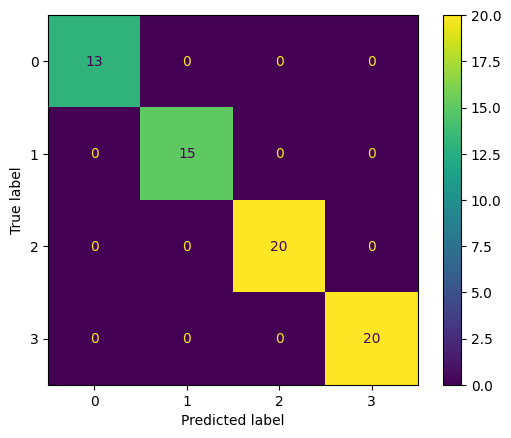

In [32]:
plt.figure(figsize = (5,5))
ConfusionMatrixDisplay(cm).plot()
plt.show()